In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def to_binary(num1, num2):
    
    num1_b = bin(num1)[2:]
    num2_b = bin(num2)[2:]
    sum_b  = bin(num1+num2)[2:]
    
    l1, l2, ls = len(num1_b), len(num2_b), len(sum_b)
    
    num1_b = '0'*(ls-l1) + num1_b
    num2_b = '0'*(ls-l2) + num2_b
        
    return num1_b, num2_b, sum_b

In [3]:
def bernoulli_noise(true_image, p):
    
    assert len(true_image.shape) == 2
    assert 0 <= p <= 1
    
    if p == 0:
        res_img = true_image
    if p == 1:
        res_img = 1 - true_image
    else:
        noise_matrix = np.zeros(true_image.shape, np.uint8)

        for i in range(true_image.shape[0]):
            for j in range(true_image.shape[1]):

                if np.random.rand() <= p:
                    noise_matrix[i, j] = 1

        res_img = true_image ^ noise_matrix
        
    plt.imshow(res_img)
    return res_img

In [4]:
def render(num_b, one_ref, zero_ref):

    char_h, char_w = one_ref.shape
    
    res = np.zeros( (char_h, char_w*len(num_b)), dtype=np.uint8 )
    
    for i in range(len(num_b)):
        
        if num_b[i] == '1':
            res[:, i*char_w :(i+1)*char_w] = one
        if num_b[i] == '0':
            res[:, i*char_w :(i+1)*char_w] = zero
    
    return res

In [5]:
def render_img(n1, n2, one_ref, zero_ref):
    
    char_h, char_w = one_ref.shape
    
    # decimal to binary
    n1_b, n2_b, _sum = to_binary(n1, n2)
    
    # render binary to img
    n1_img_clean = render(n1_b, one, zero)
    n2_img_clean = render(n2_b, one, zero)
    sum_img      = render(_sum, one, zero)
    
    # concatenate
    res_img = np.zeros( (char_h*3+1, char_w*len(n1_b)), dtype=np.uint8 )
    
    res_img[0:char_h, :] = n1_img_clean
    res_img[char_h:char_h*2, :] = n2_img_clean
    res_img[char_h*2, :] = 1
    res_img[char_h*2+1:char_h*3+1, :] = sum_img
    
    plt.imshow(res_img)
    return res_img
    

In [6]:
def generate_terminals(one, zero):
    
    char_h, char_w = one.shape
    terminals = np.zeros( (9, char_h*3+1, char_w), dtype=np.uint8 )
    
    def render_column(b1, b2, s):
        column = np.zeros( (char_h*3+1, char_w), dtype=np.uint8 )
        column[ 0          : char_h     ,:] = b1
        column[ char_h     : char_h*2   ,:] = b2
        column[ char_h*2   : char_h*2+1 ,:] = 1
        column[ char_h*2+1 : char_h*3+1 ,:] = s
        return column
        
    # C_k
    terminals[1 ,:,:] = render_column(zero, zero, zero)
    terminals[2 ,:,:] = render_column(zero, zero, one)
    terminals[3 ,:,:] = render_column(zero, one, zero)
    terminals[4 ,:,:] = render_column(one, zero, zero)
    terminals[5 ,:,:] = render_column(one, one, zero)
    terminals[6 ,:,:] = render_column(one, zero, one)
    terminals[7 ,:,:] = render_column(zero, one, one)
    terminals[8 ,:,:] = render_column(one, one, one)
    
    foo = np.concatenate((terminals[1 ,:,:], terminals[2 ,:,:], terminals[3 ,:,:], terminals[4 ,:,:], terminals[5 ,:,:], terminals[6 ,:,:], terminals[7 ,:,:], terminals[8 ,:,:]), axis=1)
    plt.imshow(foo)
    
    return terminals

In [7]:
def calculate_ref_penalty(terminals, noised_img):
    char_h, char_w = one.shape
    n = int( noised_img.shape[1] / char_w )
    
    penalties = np.full( (n,8), -1 )
    
    for i in range(n):
        for c in range(8):
            
            col = noised_img[:, char_w*i:char_w*(i+1)]
            
            diff = np.abs( col.astype(np.int8) - terminals[c+1,:,:] )
            
            penalties[i,c] = np.sum(diff)
            
    return penalties

In [8]:
one = np.array([
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,1,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,1,1,1,0],
    [0,0,0,0,0],
])

zero = np.array([
    [0,0,0,0,0],
    [0,1,1,1,0],
    [0,1,0,1,0],
    [0,1,0,1,0],
    [0,1,0,1,0],
    [0,1,0,1,0],
    [0,1,1,1,0],
    [0,0,0,0,0],
])

---

## Main

In [9]:
n1, n2,= 2, 12

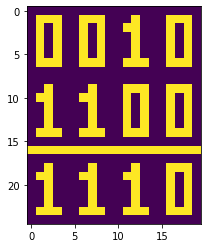

In [10]:
# Input img
inpt_img = render_img(n1, n2, one, zero)

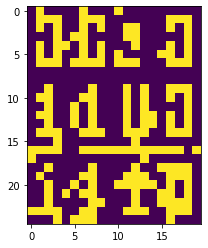

In [11]:
# Noised img
noised_img = bernoulli_noise(inpt_img, 0.1)

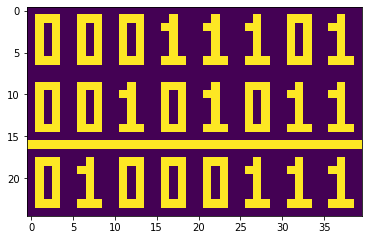

In [12]:
# C_k imgs
terminals = generate_terminals(one, zero)   

In [13]:
c_penalties = calculate_ref_penalty(terminals, noised_img)
c_penalties

array([[33, 22, 22, 44, 33, 33, 11, 22],
       [37, 28, 24, 48, 35, 39, 15, 26],
       [33, 26, 46, 24, 37, 17, 39, 30],
       [10, 19, 21, 21, 32, 30, 30, 41]])